Hunter Bennett | Glass Lab | Brain Aging Project

Before diving into deep analysis of samples we'll take a look at the crude clustering of our samples based on the peaks called for QC and IP efficiency estimation. This involves three main checks.
1. Comparing average tag counts and tag count variance for each sample.
2. Performing principal component analysis on each sample.
3. Performing clustering based in inter-sample pearson correlation

In [75]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/'
workingDirectory = '/home/h1bennet/brain_aging/results/03_Sox9_H3K27Ac_QC/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Merge peaks generated for estimating IP Efficiency

In [77]:
# %%bash
# if [ ! -d ./merged_peaks/ ]; then mkdir ./merged_peaks; fi
# mergePeaks ./peak_files/*variablewidth* > merged_peaks/all_peaks.txt

# Annotate peaks with tag counts

In [78]:
%%bash
# delete the existing script file
rm ./annotatePeaks_homer.sh
# create a script file
touch ./annotatePeaks_homer.sh

In [79]:
tagdirs_full = np.sort(glob.glob(dataDirectory+'*'))

with open('./annotatePeaks_homer.sh', 'w') as f:
    annotate_raw = ['annotatePeaks.pl', './merged_peaks/all_peaks.txt',
                    'mm10', '-size 1000', '-raw', '-d \\\n',
                    ' \\\n'.join(tagdirs_full), '>',
                    './merged_peaks/ann_raw_all_peaks.txt &\n\n']
    
    annotate_norm = ['annotatePeaks.pl', './merged_peaks/all_peaks.txt',
                     'mm10', '-size 1000', '-norm 1e7', '-d \\\n',
                     ' \\\n'.join(tagdirs_full), '>',
                     './merged_peaks/ann_norm_all_peaks.txt &\n\n']
    
    f.write(' '.join(annotate_raw))    
    f.write(' '.join(annotate_norm))
    
    f.close()

# Read in annotated peak file

In [80]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_norm_all_peaks.txt')

# # try with dropped sample
# dropsamp = ['00_mouse_BL6_M_8week_PU1_ChIP_H3K27Ac_3_AL_20191226_GTAGAG_ds']

# df = df.drop(dropsamp, axis=1)
# mat = mat.drop(dropsamp, axis=1)

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

Filter low count peaks that alter our results.  
For this crude analysis we will simply require that at least two samples have a normalized tag count above a certain threshold.

In [81]:
thresh = 8

print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
peaks = []
mat = mat.reindex(mat.index[(mat > thresh).sum(1) > 1])
mat = mat.dropna(how='all')
mat_quant = mat_quant.reindex(mat.index[(mat > thresh).sum(1) > 1])
mat_quant = mat_quant.dropna(how='all')
print(mat.shape[0], 'total peaks')

mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
mat_distal.dropna(inplace=True)

39057 total peaks
filtering low tag count peaks
38059 total peaks


# Make Summary Plots

In [82]:
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

## Mean-Variance Plot

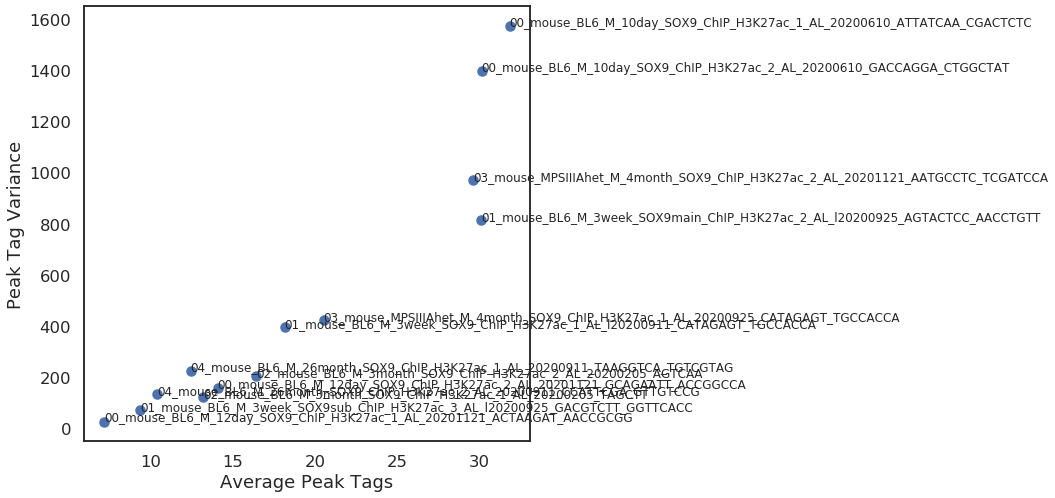

In [83]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(mat.mean(), mat.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat.mean(),
            mat.var(),
            mat.columns.str.split('/').str[-1],
            plt.gca())

plt.savefig('./figures/mean_variance_plot.png', bbox_inches='tight')

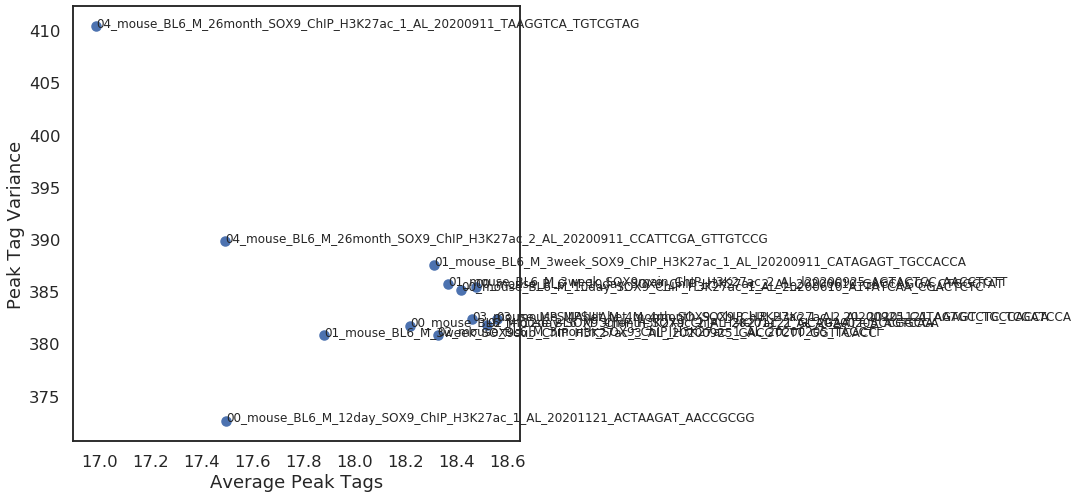

In [84]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(mat_quant.mean(), mat_quant.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat_quant.mean(),
            mat_quant.var(),
            mat_quant.columns.str.split('/').str[-1],
            plt.gca())

plt.savefig('./figures/mean_variance_plot_quantnorm.png', bbox_inches='tight')

## Sample correlation heatmap

In [85]:
mat.columns = mat.columns.str.split('/').str[-1]
mat_quant.columns = mat_quant.columns.str.split('/').str[-1]
mat_distal.columns = mat_distal.columns.str.split('/').str[-1]

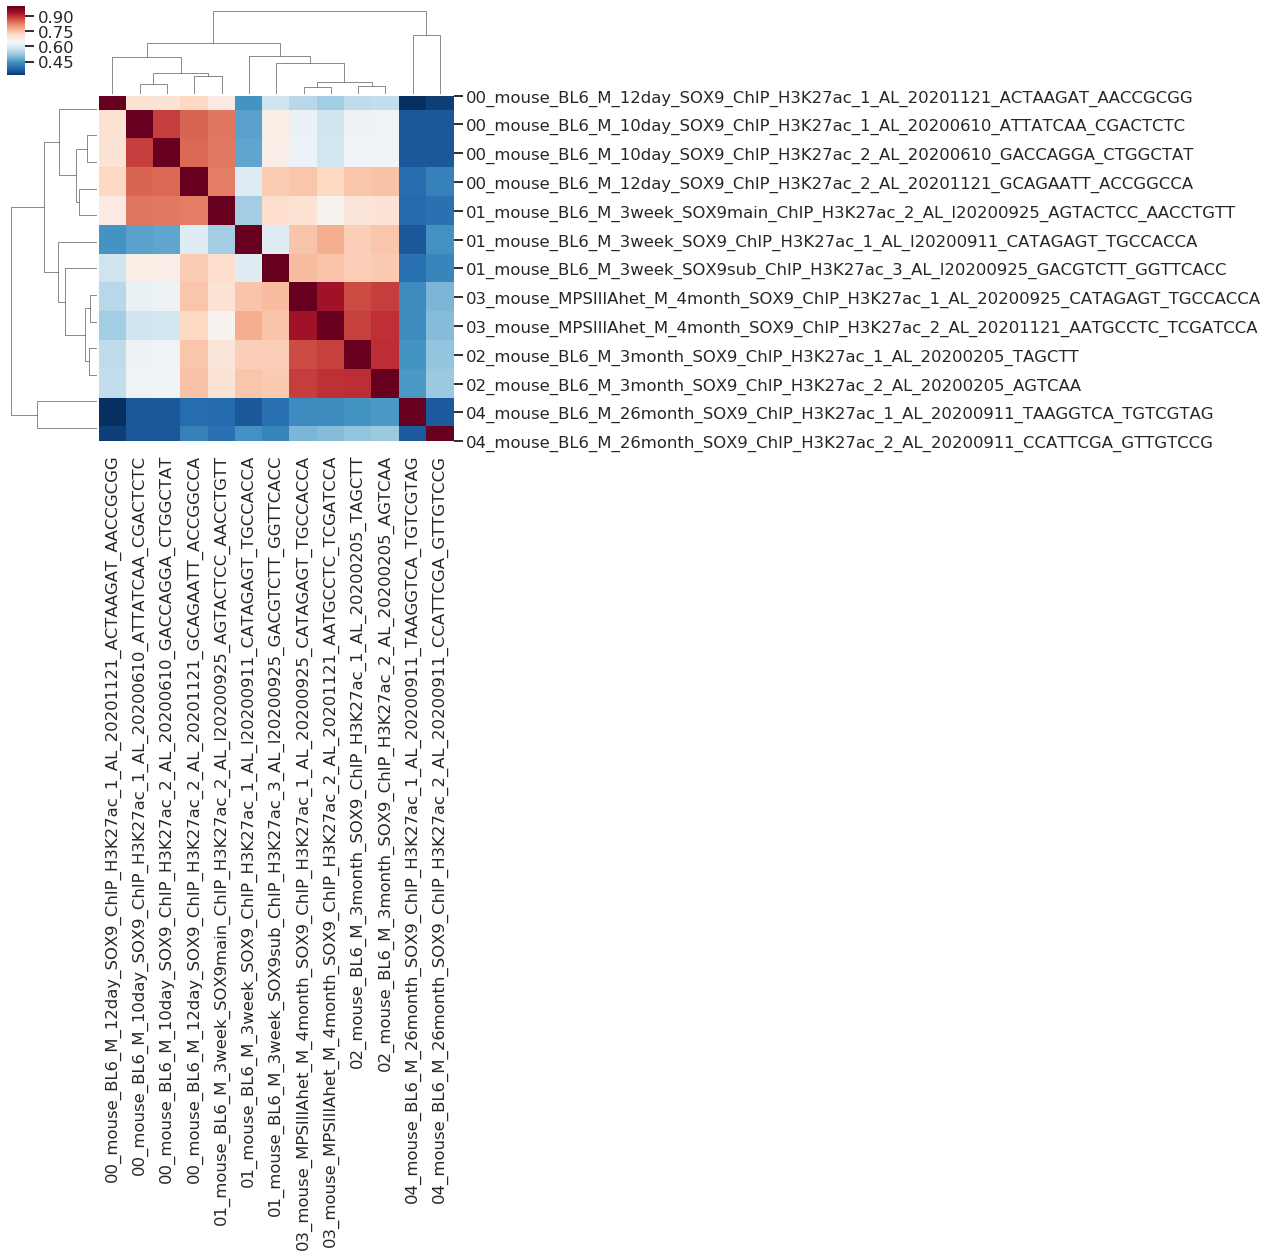

In [86]:
cm = sns.clustermap(
    mat.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/h3k27ac_correlation_heatmap.png', bbox_inches='tight')

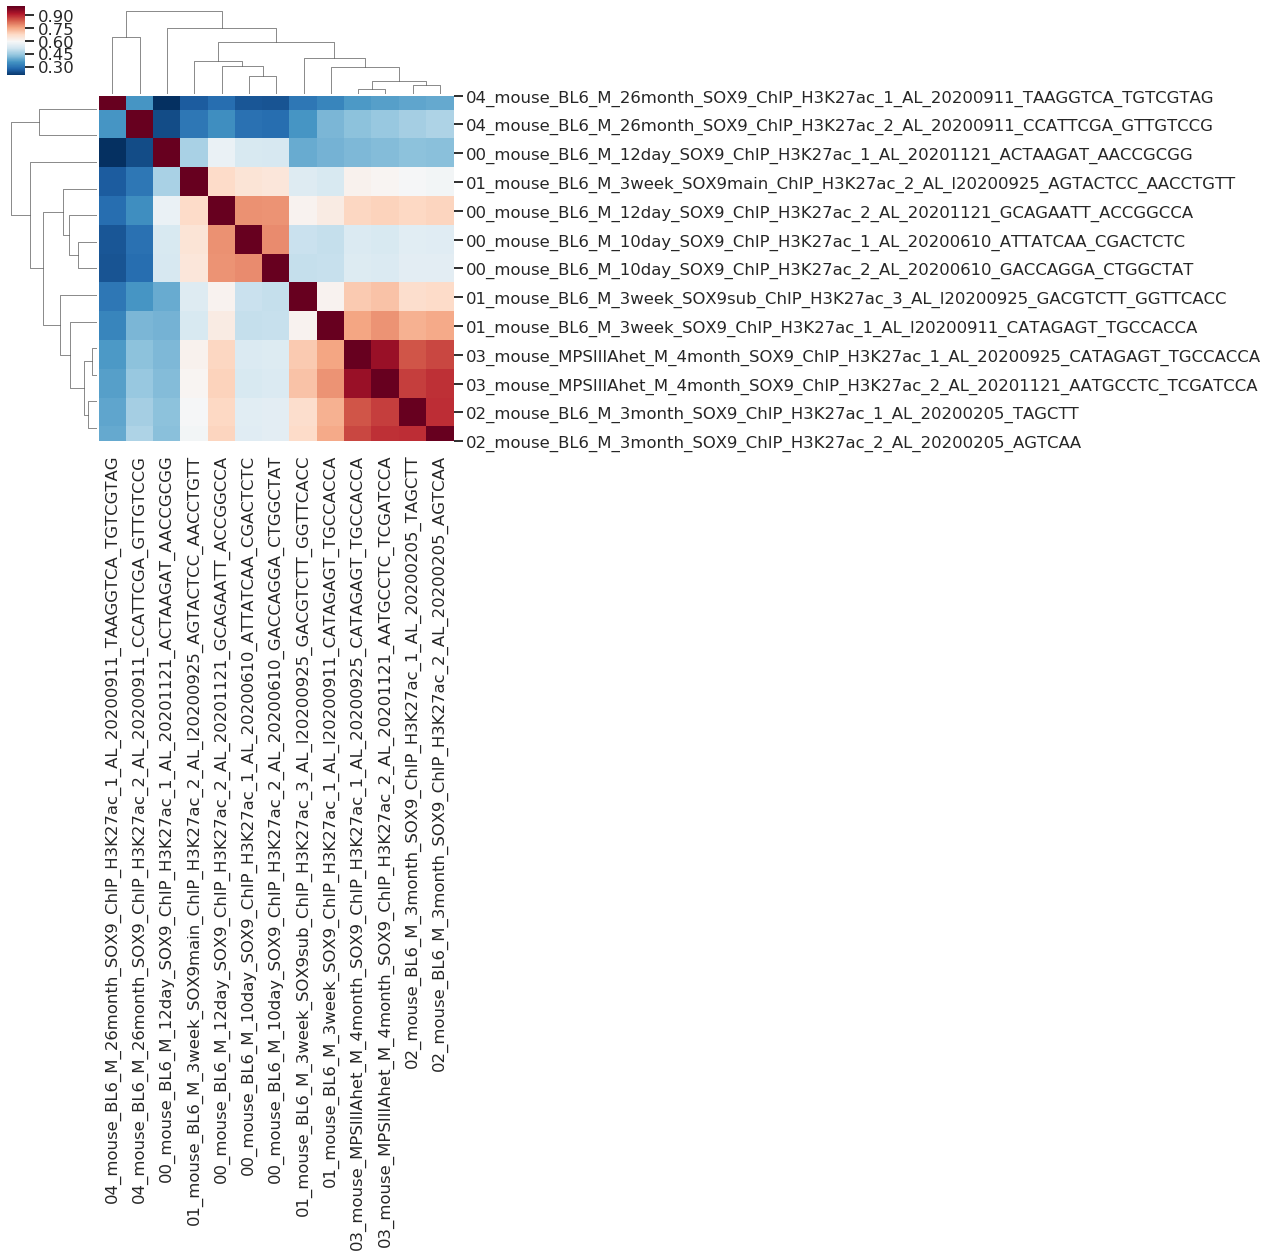

In [87]:
cm = sns.clustermap(
    mat_distal.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/h3k27ac_correlation_heatmap_distal.png', bbox_inches='tight')

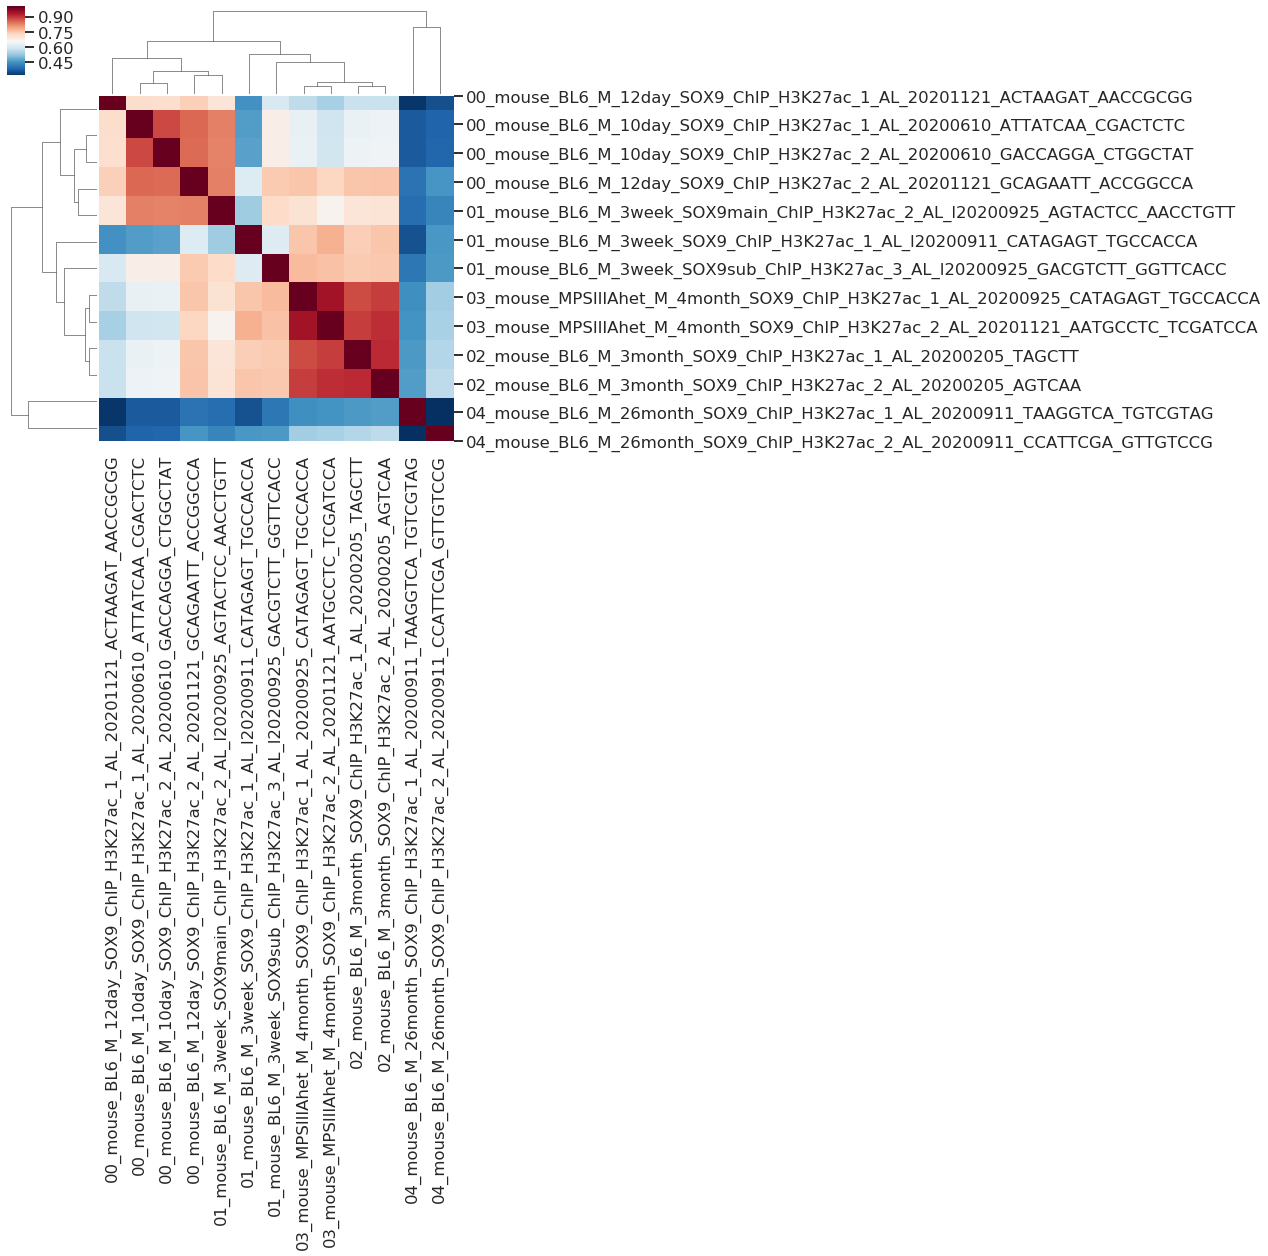

In [88]:
cm = sns.clustermap(
    mat_quant.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/h3k27ac_correlation_heatmap_quantnorm.png', bbox_inches='tight')

## Principal component analysis

In [89]:
# this part must be done manually - use the sample ID fields to pick out
# identifiers for each sample.
samples = pd.Series(mat.columns)
group = samples.str.split('_').str[0]
strain = samples.str.split('_').str[2]
gender = samples.str.split('_').str[3]
age = samples.str.split('_').str[4]
cell = samples.str.split('_').str[5]
rep = samples.str.split('_').str[8]
sampledate = samples.str.split('_').str[9]
                                        
samplesDF = pd.DataFrame([pd.Series(samples),
                          pd.Series(group),
                          pd.Series(strain),
                          pd.Series(gender),
                          pd.Series(age),
                          pd.Series(cell),
                          pd.Series(rep),
                          pd.Series(sampledate)],
                         index=['mouse',
                                'group',
                                'strain',
                                'gender',
                                'age',
                                'celltype',
                                'rep',
                                'sample_date']).T

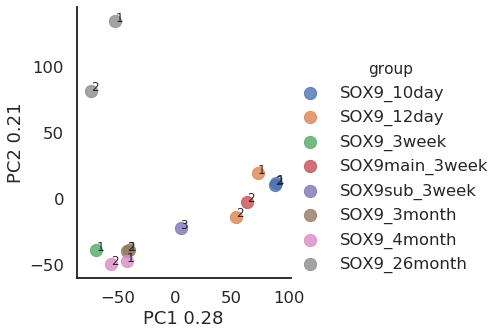

In [90]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/h3k27ac_pca1_pca2.png', bbox_inches='tight')

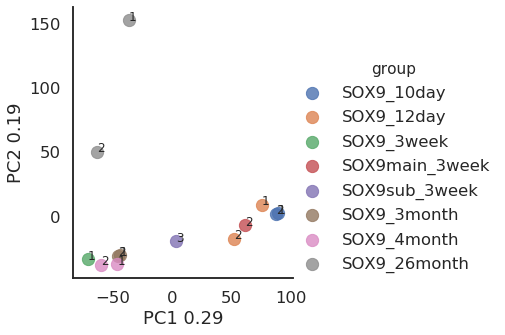

In [91]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_quant,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/h3k27ac_quantnorm_pca1_pca2.png', bbox_inches='tight')

# Next: filter samples that have poor QC and remake plots

In [114]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_norm_all_peaks.txt')

# try with dropped sample
dropsamp = ['00_mouse_BL6_M_12day_SOX9_ChIP_H3K27ac_1_AL_20201121_ACTAAGAT_AACCGCGG',
            '00_mouse_BL6_M_12day_SOX9_ChIP_H3K27ac_2_AL_20201121_GCAGAATT_ACCGGCCA',
            '01_mouse_BL6_M_3week_SOX9sub_ChIP_H3K27ac_3_AL_l20200925_GACGTCTT_GGTTCACC',
            '02_mouse_BL6_M_3month_SOX9_ChIP_H3K27ac_1_AL_20200205_TAGCTT',
            '04_mouse_BL6_M_26month_SOX9_ChIP_H3K27ac_1_AL_20200911_TAAGGTCA_TGTCGTAG',
            '04_mouse_BL6_M_26month_SOX9_ChIP_H3K27ac_2_AL_20200911_CCATTCGA_GTTGTCCG']

dropcols = df.columns[df.columns.str.contains('|'.join(dropsamp))].tolist()

df = df.drop(columns=dropcols)
mat = mat.drop(columns=dropcols)

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

Filter low count peaks that alter our results.  
For this crude analysis we will simply require that at least two samples have a normalized tag count above a certain threshold.

In [115]:
thresh = 8

print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
peaks = []
mat = mat.reindex(mat.index[(mat > thresh).sum(1) > 1])
mat = mat.dropna(how='all')
mat_quant = mat_quant.reindex(mat.index[(mat > thresh).sum(1) > 1])
mat_quant = mat_quant.dropna(how='all')
print(mat.shape[0], 'total peaks')

mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
mat_distal.dropna(inplace=True)

39057 total peaks
filtering low tag count peaks
36740 total peaks


## Mean-Variance Plot

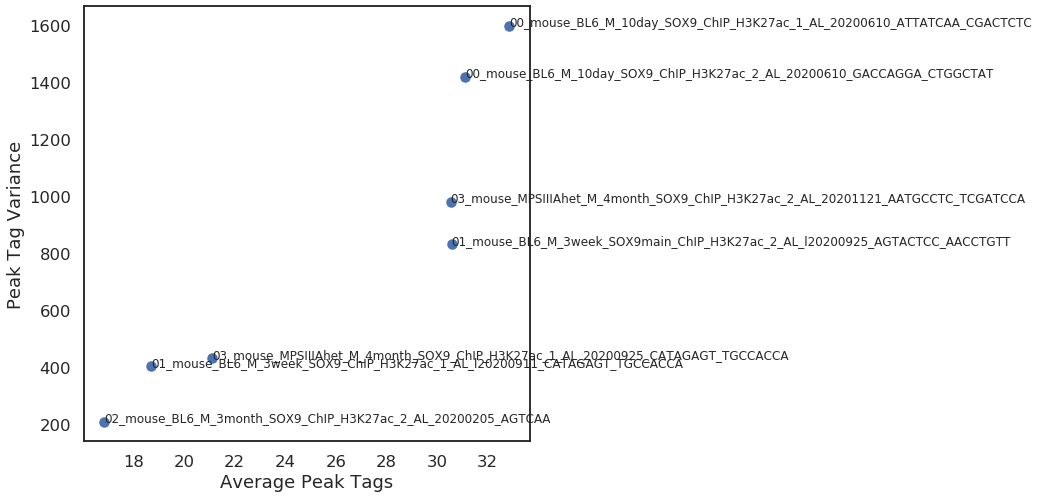

In [116]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(mat.mean(), mat.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat.mean(),
            mat.var(),
            mat.columns.str.split('/').str[-1],
            plt.gca())

plt.savefig('./figures/samp_filt_mean_variance_plot.png', bbox_inches='tight')

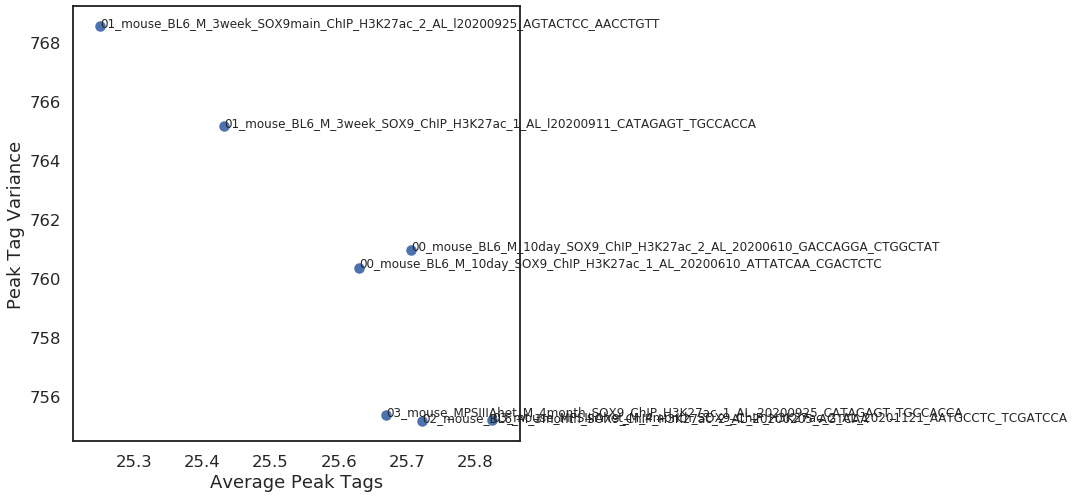

In [117]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(mat_quant.mean(), mat_quant.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat_quant.mean(),
            mat_quant.var(),
            mat_quant.columns.str.split('/').str[-1],
            plt.gca())

plt.savefig('./figures/samp_filt_mean_variance_plot_quantnorm.png', bbox_inches='tight')

## Sample correlation heatmap

In [118]:
mat.columns = mat.columns.str.split('/').str[-1]
mat_quant.columns = mat_quant.columns.str.split('/').str[-1]
mat_distal.columns = mat_distal.columns.str.split('/').str[-1]

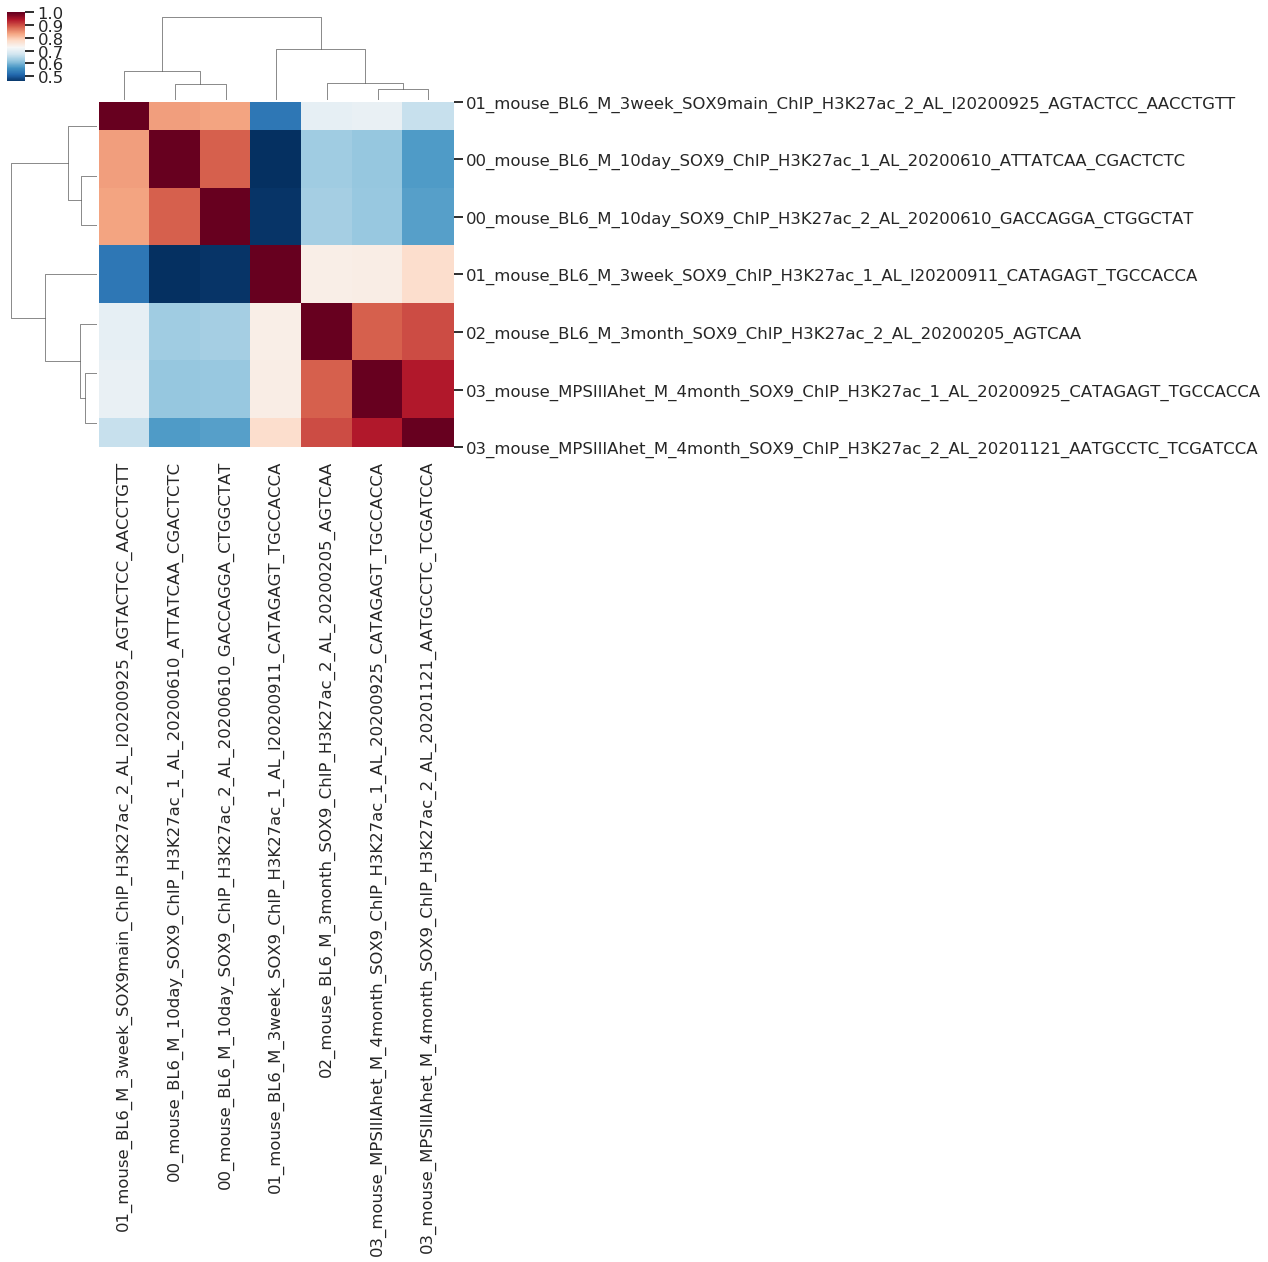

In [119]:
cm = sns.clustermap(
    mat.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/samp_filt_h3k27ac_correlation_heatmap.png', bbox_inches='tight')

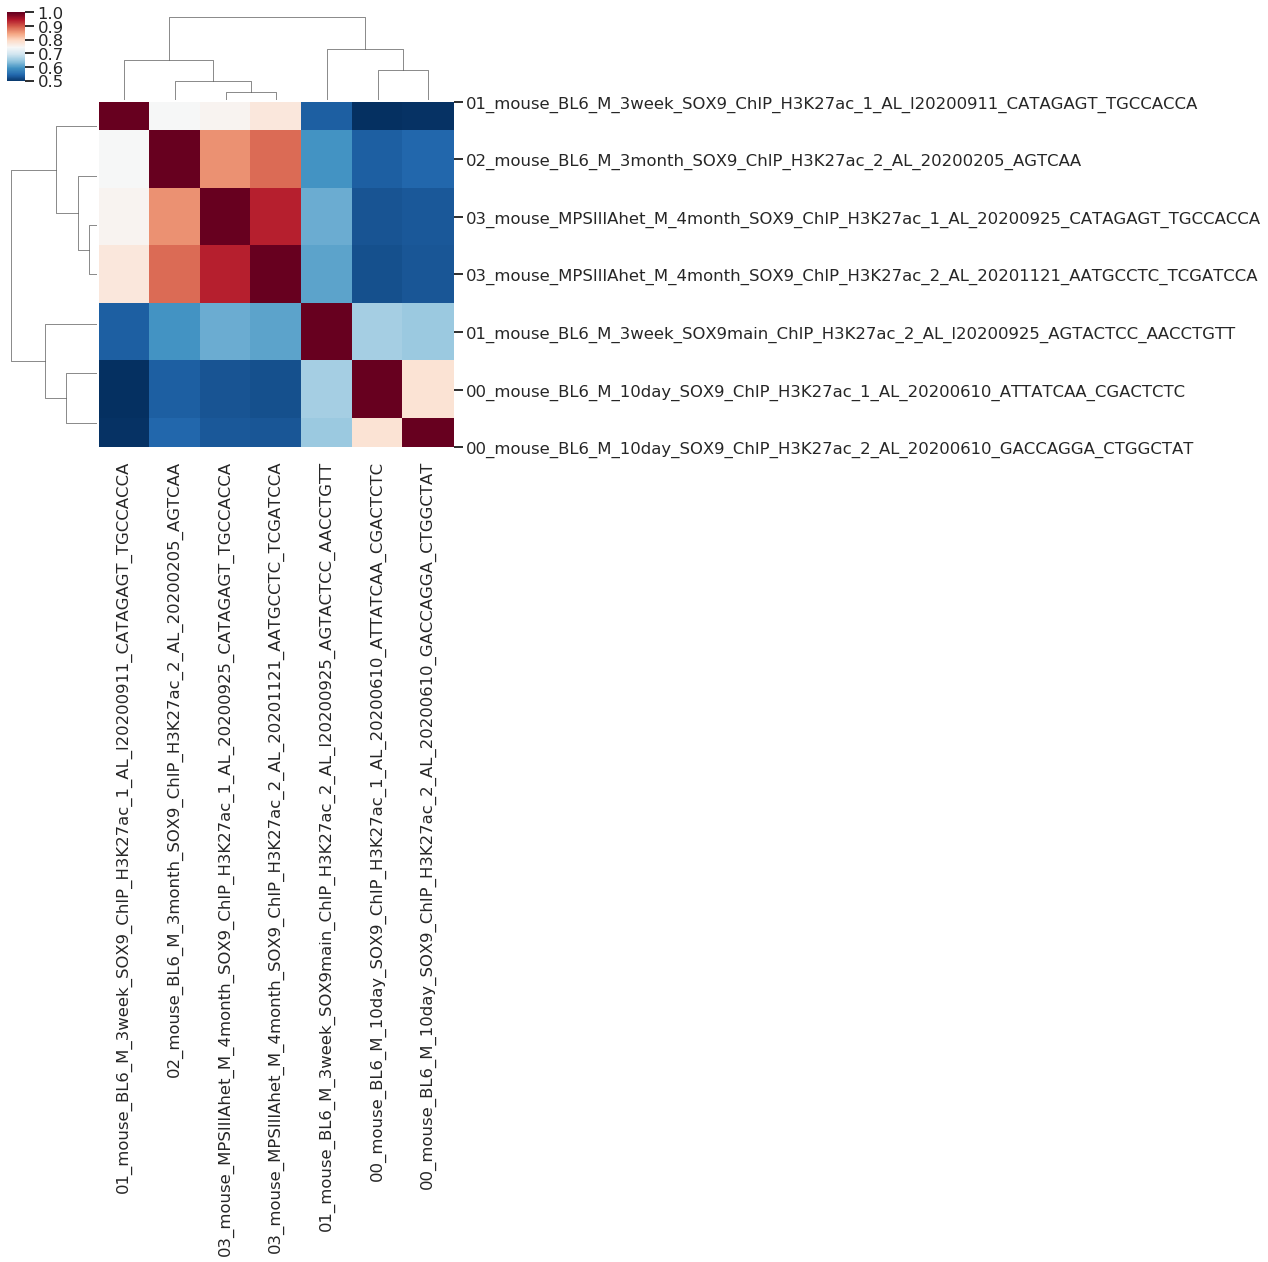

In [120]:
cm = sns.clustermap(
    mat_distal.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/samp_filt_h3k27ac_correlation_heatmap_distal.png', bbox_inches='tight')

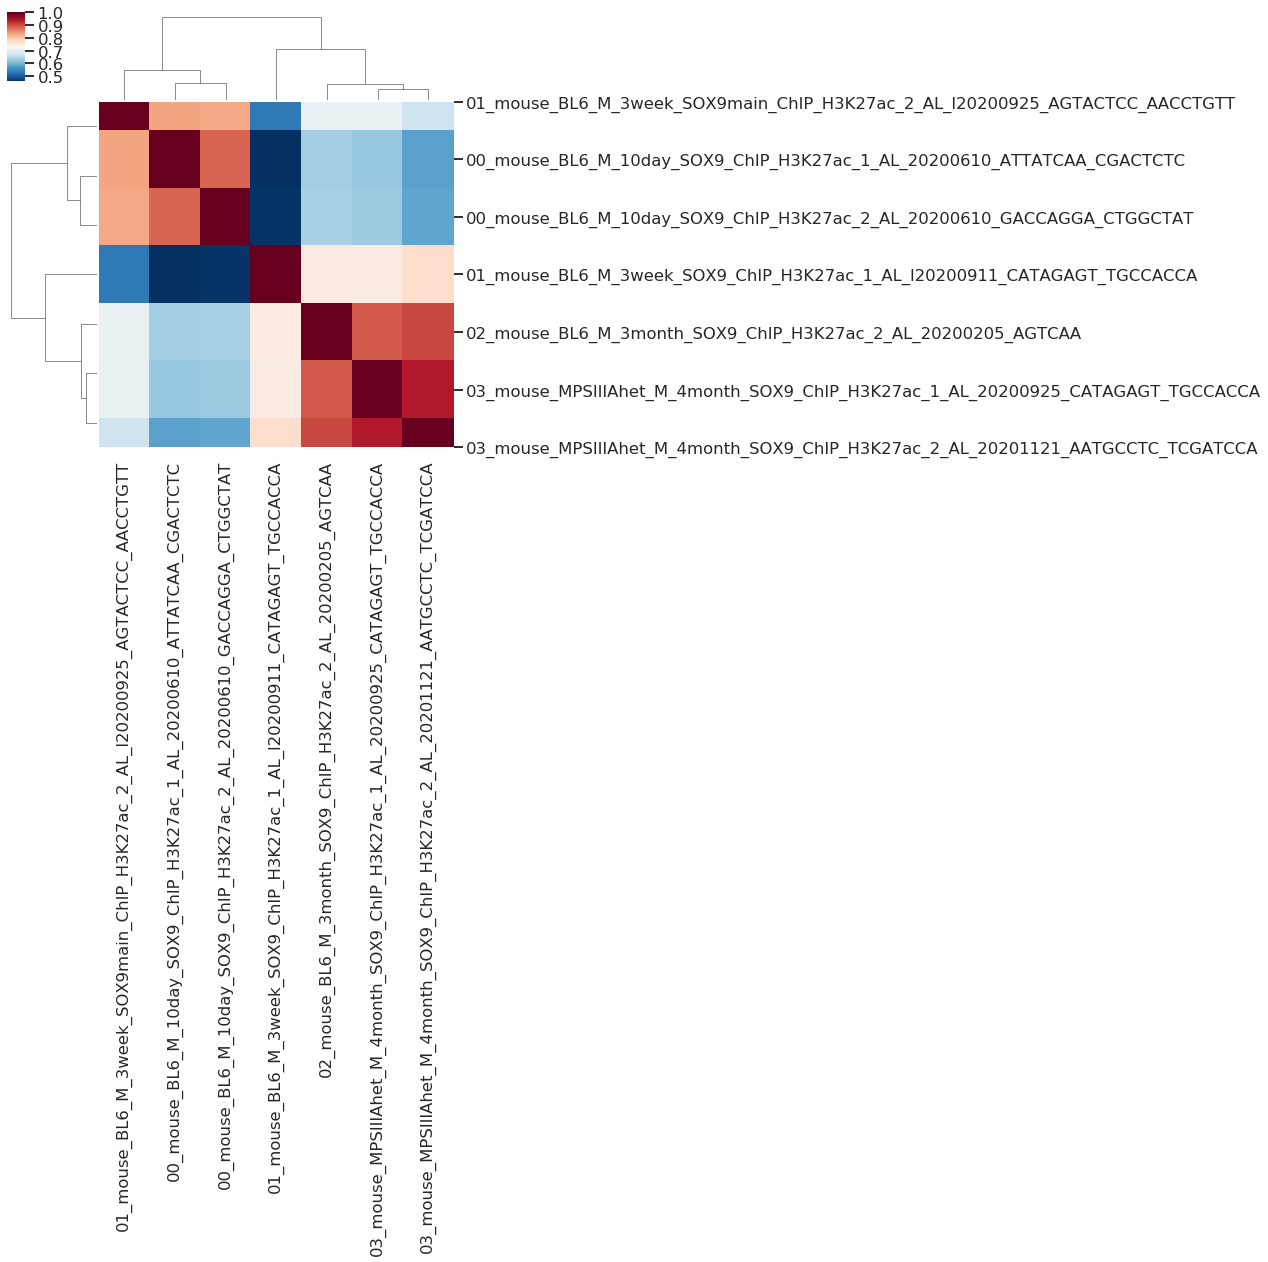

In [121]:
cm = sns.clustermap(
    mat_quant.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/samp_filt_h3k27ac_correlation_heatmap_quantnorm.png', bbox_inches='tight')

## Principal component analysis

In [122]:
# this part must be done manually - use the sample ID fields to pick out
# identifiers for each sample.
samples = pd.Series(mat.columns)
group = samples.str.split('_').str[0]
strain = samples.str.split('_').str[2]
gender = samples.str.split('_').str[3]
age = samples.str.split('_').str[4]
cell = samples.str.split('_').str[5]
rep = samples.str.split('_').str[8]
sampledate = samples.str.split('_').str[9]
                                        
samplesDF = pd.DataFrame([pd.Series(samples),
                          pd.Series(group),
                          pd.Series(strain),
                          pd.Series(gender),
                          pd.Series(age),
                          pd.Series(cell),
                          pd.Series(rep),
                          pd.Series(sampledate)],
                         index=['mouse',
                                'group',
                                'strain',
                                'gender',
                                'age',
                                'celltype',
                                'rep',
                                'sample_date']).T

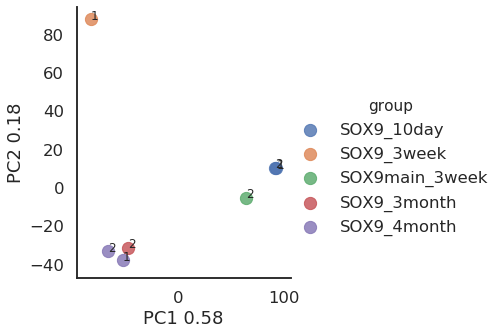

In [123]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/samp_filt_h3k27ac_pca1_pca2.png', bbox_inches='tight')

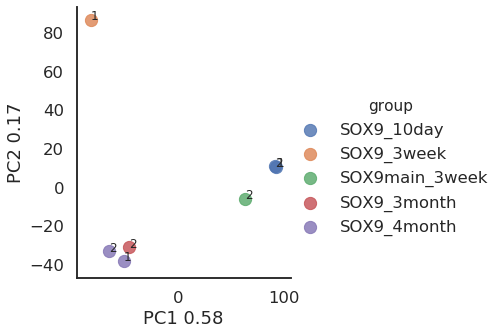

In [124]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_quant,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/samp_filt_h3k27ac_quantnorm_pca1_pca2.png', bbox_inches='tight')

Despite their low (10M reads compared to 20M for other samples) read count, the 10day SOX9 samples appear to be properly clustering with the 12 day and 3 week samples, which would be independent of IP efficiency since their is a wide variance of IP efficiencies. One additional question is whether **01_mouse_BL6_M_3week_SOX9_ChIP_H3K27ac_1_AL_l20200911_CATAGAGT_TGCCACCA_variablewidth_peaks.tsv** is an outlier? It is the most clonal sample but it would be nice to use it while we are waiting for the 10day Sox9 samples to be sequenced more deeply.

# Browser shots

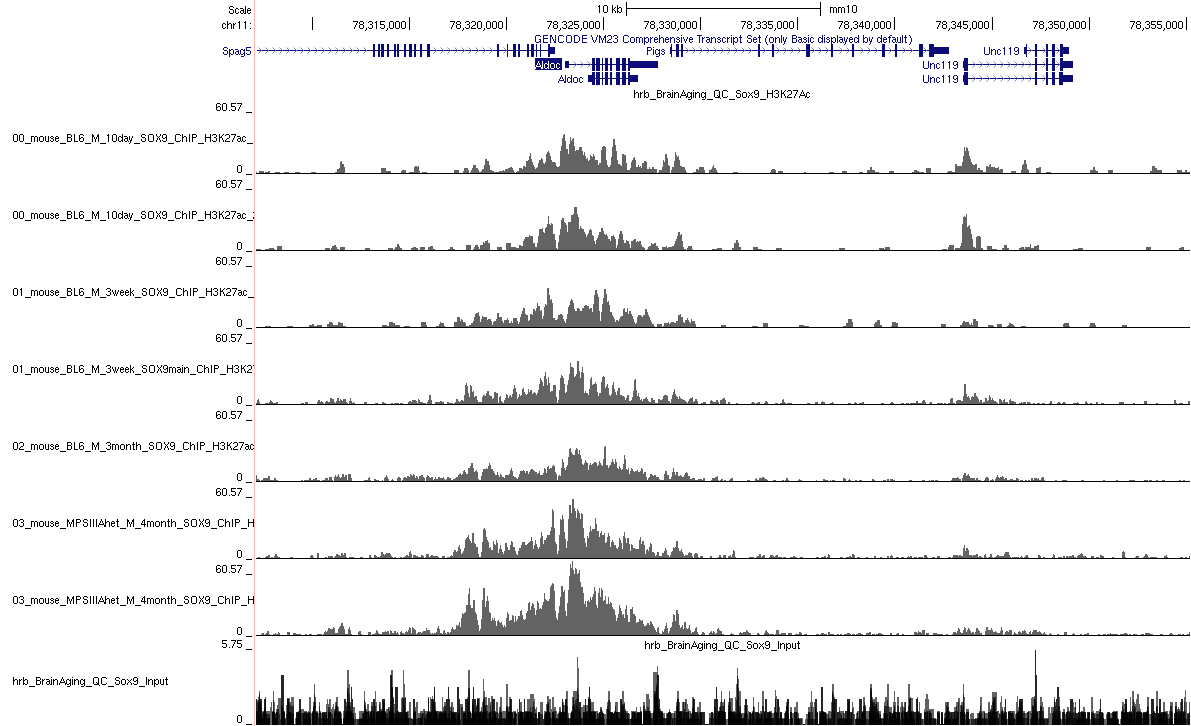

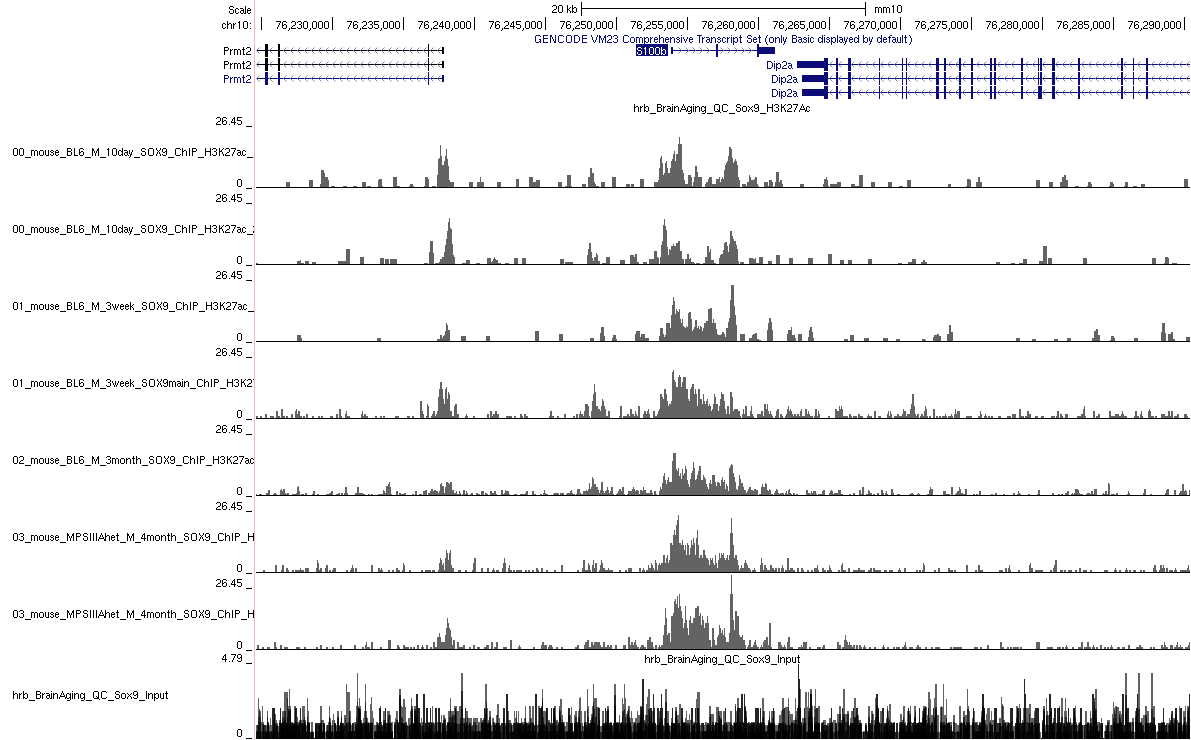

The C1ql1 enhancer could be an example of Sox9 3 week sample 1 clustering with the older samples over the younger samples.

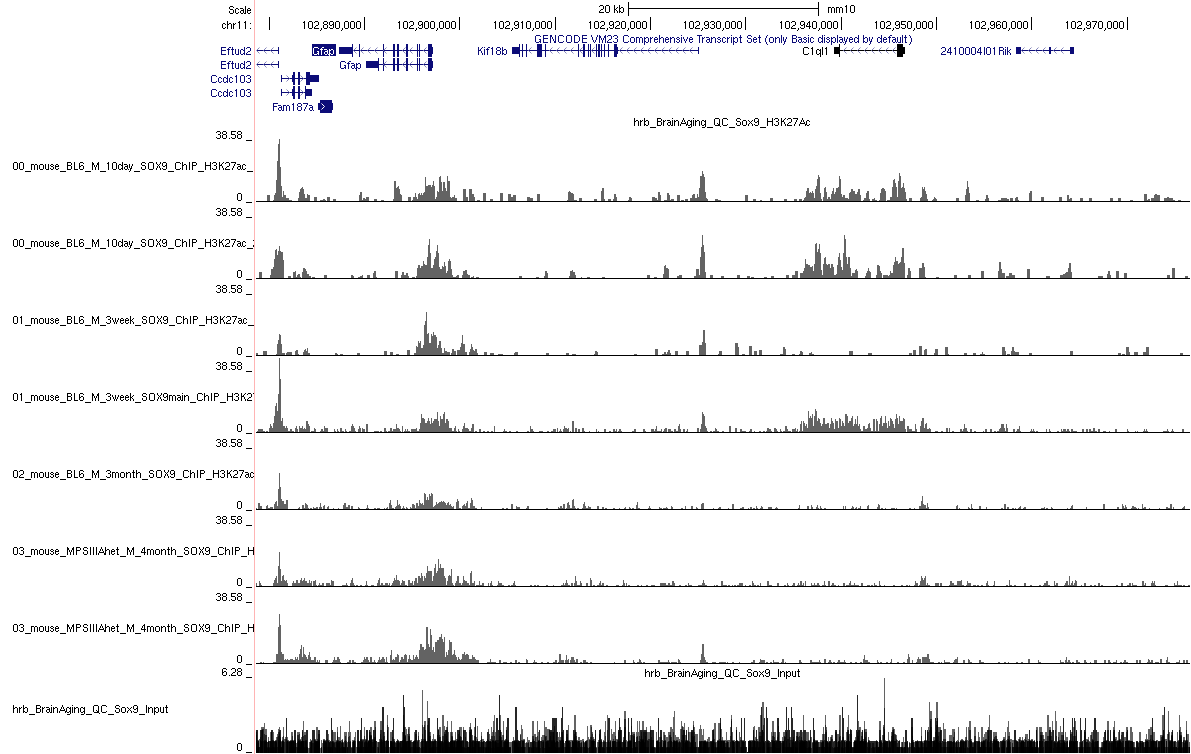